# LO vs. NLO simulation 

In this exercise we will get familiar with leading order (LO) and next-to-leading order (NLO) simulation. As you might know, beyond the tree level things can get messy. The NLO Feynman diagrams (diagrams with one loop) need to be taken into account and for instance the cross section calculation becomes harder. The NLO diagrams influence the experimental results as well. 

Your task this week is to analyse two datasets. One is a ttbar process (a process that produces a top quark and an anti-top quark) simulated in LO and the other is a ttbar process in NLO. These simulations have been made in the framework of CMS detector by following the circumstances of 2016 data taking. This means that we are looking at proton-proton collisions with $\sqrt{s}$ = 13 TeV center-of-mass energy. 

In the normalisation use need to know the theoretical cross section of the process. We assume the mass of the top quark to be 172.5 GeV.
The latest calculated theoretical cross section is then 831.76 pb.

In this exercise we are studying jets. Jets are collimated sprays of hadrons. Since the lifetime of a top quark is very short, it decays into a jet which is then measured. The difference of LO and NLO can be seen for instance in the jet distributions.

We have so far used csv files in our studies. In particle physics however we use quite a lot of .root files. Therefore we will get familiar with .root files in this exercise as well. Below is an example of how to read and loop over the data. Note that the data is nested. Each particle collision event may create multiple jets. To find the data for each jet separately one must have two nested loops, one looping over the events and the other looping through the jets of the event.

An example of going through the data can be seen below. It saves the transverse momentum and pseudorapidity of each jet to their own lists. The transverse momenta are obtained using a variable called 'Jets_pt_MCjet' and the psedurapidities using 'Jets_eta_MCjet'.

In [223]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import uproot

# Read the data sets tt_LO.csv and tt_NLO.csv

f_NLO = uproot.open('tt_NLO.root')
tree_NLO = f_NLO.get('Events')
f_LO = uproot.open('tt_LO.root')
tree_LO = f_LO.get('Events')

#Here is an example of how to gather jet pts and pseudorapidities:

jet_pts = []
jet_etas = []
        
no_of_events = len(tree_NLO.array('Jets_pt_MCjet'))
for i in range(no_of_events):
    no_of_jets = len(tree_NLO.array('Jets_pt_MCjet')[i])
    for j in range(no_of_jets):
        jet_pts.append(tree_NLO.array('Jets_pt_MCjet')[i][j])
        jet_etas.append(tree_NLO.array('Jets_eta_MCjet')[i][j])
        
# An alternate way to loop which is shorter to write and quicker to run but less versatile:

#for event_pts in tree_NLO.array('Jets_pt_MCjet'): 
#    for pt in event_pts:
#        jet_pts.append(pt)


print('The pT of the first jet is', round(jet_pts[0],2), 'GeV') # 132.37
print('Its pseudorapidity is', round(jet_etas[0],2)) # 0.75

The pT of the first jet is 132.37 GeV
Its pseudorapidity is 0.75


### Part 1: LO and NLO jet counts

The first task is to plot the numbers of jets per event in a histogram and compare the obtained distributions for LO and NLO. In other words, loop over the events and for each event calculate the number of jets (entries) it contains.

We want to have a lower limit of transverse momentum for jets to be included in our analysis. Check from Moodle at "Week 5 coding questions" which cut you should use. Only count the jets that have a higher pT than your cut.

NOTE: The simulated events need to be weighted. Each event has a weight assigned to it which can be found using variable GenWeight. You need to loop over the events to collect an array of weights as well. Use that as input for the argument 'weights' when plotting the histogram using plt.hist. In the NLO simulation you might notice that some weights are negative. The negative weights are an artifact of the cross section calculation. There some terms get a negative weight from a fermion loop.  Also normalize the histograms.

Return the averages and standard deviations for both datasets. Does including NLO Feynman diagrams actually make a difference in practice?

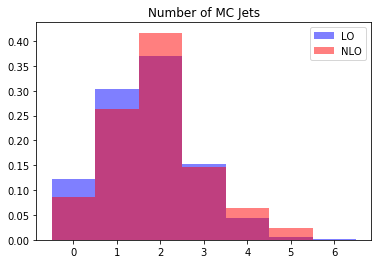

Average for LO:  1.7140825035561877
Average for NLO:  1.9064039408866995
SD for LO:  1.0557238038189345
SD for NLO:  1.110233798829457


In [216]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import uproot

# Plot the number of MC jets after cuts for LO and NLO

weights_jets_NLO = []
weights_jets_LO = []
jets_per_event_NLO = []
jets_per_event_LO = []

pt_cut = 60

for jets_pt in tree_NLO.array('Jets_pt_MCjet'):
    i = 0
    for event_pt in jets_pt:
        if event_pt > pt_cut:
            i += 1
    jets_per_event_NLO.append(i)
    
for weight in tree_NLO.array('GenWeight'):
    weights_jets_NLO.append(weight)
    
for jets_pt in tree_LO.array('Jets_pt_MCjet'):
    i = 0
    for event_pt in jets_pt:
        if event_pt > pt_cut:
            i += 1
    jets_per_event_LO.append(i)
    
for weight in tree_LO.array('GenWeight'):
    weights_jets_LO.append(weight)
    

bins = np.arange(0, max(jets_per_event_LO) + 1.5) - 0.5
plt.hist(jets_per_event_LO, bins=bins, weights=weights_jets_LO, color='b', density=True, alpha=0.5, label='LO')
plt.hist(jets_per_event_NLO, bins=bins, weights=weights_jets_NLO, color='r', density=True, alpha=0.5, label='NLO')


plt.title('Number of MC Jets')
plt.legend()
plt.show()

print('Average for LO: ', np.average(jets_per_event_LO))
print('Average for NLO: ', np.average(jets_per_event_NLO))
print('SD for LO: ', np.std(jets_per_event_LO))
print('SD for NLO: ', np.std(jets_per_event_NLO))

### Part 2: Plotting pT

In this part we will take a look at the transverse momenta of individual jets in one of the datasets we have. Plot the transverse momentum for the accepted jets in a histogram. Again use the weights (all jets in the same event have the same weight) and normalize the pT distribution. Use 50 bins for the histogram.

Check from Moodle whether you should use the NLO or the LO dataset. Choose this time the accepted jets using both the momentum of the particles and their pseudorapidities as discriminators. The ranges which you should use are also on Moodle.

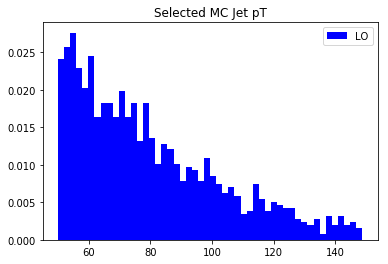

In [240]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import uproot

# Plot the jet pT after cuts

pt_lower_lim = 50
pt_upper_lim = 150
eta_lim = 2.1
bin_no = 50

LO_pts = []
weights_LO = []          

for i in range(len(tree_LO.array('event'))):
    for j in range(len(tree_LO.array('Jets_pt_MCjet')[i])):
        eta = tree_LO.array('Jets_eta_MCjet')[i][j]
        pt = tree_LO.array('Jets_pt_MCjet')[i][j]
        if abs(eta) < eta_lim and pt > pt_lower_lim and pt < pt_upper_lim:
            LO_pts.append(pt)
            weights_LO.append(tree_LO.array('GenWeight')[i])

plt.hist(LO_pts, bins=bin_no, weights=weights_LO, color='b', density=True, label='LO')

plt.title('Selected MC Jet pT')
plt.legend()
plt.show()

### Part 3: Fitting an exponential

The data you plotted should look like it could be reasonably modelled by an exponentially decaying function. Let's train curve fitting once more and try to fit an exponential curve $c_1e^{c_2x}$ to the data ($c_1$ and $c_2$ are constants).

We have used scipy.curve_fit before, but here we can be smarter than that. The easiest way to do this is to realize that an exponential curve is just a straight line after taking a logarithm. Therefore you can take the natural
logarithms of bin heights and fit a straight line $ax+b$ to them using [numpy.polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) (fitting polynomials is in general quite easy and much less frustrating than arbitrary functions). The exponential curve is then $e^be^{ax}$.

Write a function exponential fit which takes as inputs 'heights' and 'bin_edges', the first two return values given by plt.hist. It calculates the histogram centers and then fits a line to log(heights) using np.polyfit. Return the values $a$ and $e^b$ (NOT just b) **in this order**. Return two separate values, not a list. You can return multiple values by separating them with a comma.

**Submit** the function via Moodle.

In [235]:
# Write a function exponential_fit

def exponential_fit(heights, bin_edges):
    bin_centers = [0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bins)-1)]
    par = np.polyfit(bin_centers, np.log(heights), 1)
    return par[0], np.exp(par[1])

Check by plotting that the curve created by your function fits reasonably well to the data. Return the parameters $a$ and $e^b$ for your data.

a: -0.029169978800169794
e^b: 0.13281173625415454


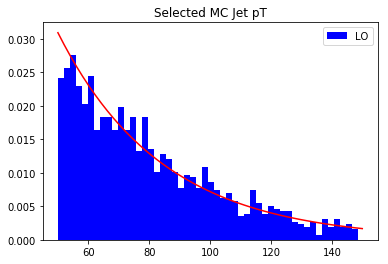

In [237]:
# Fit an exponential curve to the data. 

heights, bin_edges, patches = plt.hist(LO_pts, bins=bin_no, weights=weights_LO, color='b', density=True, label='LO')

a, eb = exponential_fit(heights, bin_edges)

print('a:', a)
print('e^b:', eb)

plt.plot(x, eb*np.exp(a*x), 'r')
plt.title('Selected MC Jet pT')
plt.legend()
plt.show()